In [1]:
import pacmap
import numpy as np
import pickle
from matplotlib import pyplot as plt
from annoy import AnnoyIndex
import torch

In [2]:
from collections import defaultdict
import itertools

def cosine_similarity_np(a, b):
    """Compute cosine similarity between two 1D numpy arrays."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

def plot_cosine_similarity_distributions(similarity_data, bins=50):
    """
    Plots histograms of same-class and different-class cosine similarities.
    
    Args:
        similarity_data: dict with keys 'same_class_sims' and 'diff_class_sims'
        location: optional int, the location index for title annotation
        bins: int, number of bins in the histogram
    """
    same_class_sims = similarity_data["same_class_sims"]
    diff_class_sims = similarity_data["diff_class_sims"]
    location = similarity_data["location"]
    
    plt.figure(figsize=(8, 5))
    plt.hist(same_class_sims, bins=bins, alpha=0.6, label='Same Class', color='green', density=True)
    plt.hist(diff_class_sims, bins=bins, alpha=0.6, label='Different Class', color='red', density=True)
    
    plt.axvline(np.mean(same_class_sims), color='green', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(diff_class_sims), color='red', linestyle='dashed', linewidth=1)

    plt.title(f"Cosine Similarity Distributions{f' @ Location {location}' if location is not None else ''}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def look_at_cosine_similarity_between_latent_embeddings(data):
    """
    Args:
        vecs: list of numpy arrays of shape (64, 1, 40)
        ys: list of labels (ints or strings)
        location: int, the spatial index to slice out (0 to 39)
    """
    X_transformed_prototypes, X_transformed_samples, prototypes, ys, classes, class_names, _, location, vecs = data
    # Extract 64-dimensional vector at the given location from each sample
    # Group by class
    class_to_vecs = defaultdict(list)
    for vec, y in zip(vecs, ys):
        class_to_vecs[y].append(vec)

    # Compute same-class similarities
    same_class_sims = []
    for vec_list in class_to_vecs.values():
        for v1, v2 in itertools.combinations(vec_list, 2):
            sim = cosine_similarity_np(v1, v2)
            same_class_sims.append(sim)

    # Compute different-class similarities
    different_class_sims = []
    class_labels = list(class_to_vecs.keys())
    for i in range(len(class_labels)):
        for j in range(i + 1, len(class_labels)):
            class_i_vecs = class_to_vecs[class_labels[i]]
            class_j_vecs = class_to_vecs[class_labels[j]]
            for v1 in class_i_vecs:
                for v2 in class_j_vecs:
                    sim = cosine_similarity_np(v1, v2)
                    different_class_sims.append(sim)

    # Summary
    print(f"Location {location} | Avg Same-Class Cosine Sim: {np.mean(same_class_sims):.4f}")
    print(f"Location {location} | Avg Different-Class Cosine Sim: {np.mean(different_class_sims):.4f}")

    return {
        "same_class_sims": same_class_sims,
        "diff_class_sims": different_class_sims,
        "location": location
    }

def fit_data(path, location, proto_location=None):
    data_ojbect = {}
    with open(path, "rb") as f:
        data_ojbect = pickle.load(f)
        f.close()

    classes = data_ojbect["classes"]
    class_names = data_ojbect["class_names"]

    vecs = []
    ys = []
    prototypes = None
    for c in classes:
        if c == "prototype":
            prototypes = classes[c][:,:,0,0]
            continue

        vecs = vecs + classes[c]
        ys = ys + [c] * len(classes[c])

    vecs = np.array(vecs)

    # Normalize the vectors
    vecs = vecs
    # Normalize the prototypes
    prototypes = prototypes 

    # print(np.arccos(prototypes[:, -2] / np.linalg.norm(prototypes[:, -2:], axis=1, keepdims=True)) / 2 / np.pi * 40)

    prototypes = prototypes / np.linalg.norm(prototypes, axis=1, keepdims=True)
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    print(vecs[0, -16:, 0])

    # Only keep prototypes for which idx % 40 == proto_location
    if proto_location is not None:
        new_protos = []

        for i in range(prototypes.shape[0]):
            if i % 40 == proto_location:
                new_protos.append(prototypes[i])
        prototypes = np.array(new_protos)
        print(prototypes.shape)
    else:
        prototypes = prototypes

    vecs = vecs[:,:,location]

    vecs_catted_with_prototypes = np.concatenate((vecs, prototypes), axis=0)

    X = vecs_catted_with_prototypes
    n, dim = X.shape
    n_neighbors = 10
    tree = AnnoyIndex(dim, metric='dot')
    for i in range(n):
        tree.add_item(i, X[i, :])
    tree.build(20)

    nbrs = np.zeros((n, 20), dtype=np.int32)
    for i in range(n):
        nbrs_ = tree.get_nns_by_item(i, 20 + 1)  # The first nbr is always the point itself
        nbrs[i, :] = nbrs_[1:]

    scaled_dist = np.ones((n, n_neighbors))  # No scaling is needed

    # Type casting is needed for numba acceleration
    X = X.astype(np.float32)
    scaled_dist = scaled_dist.astype(np.float32)

    # make sure n_neighbors is the same number you want when fitting the data
    pair_neighbors = pacmap.sample_neighbors_pair(X, scaled_dist, nbrs, np.int32(n_neighbors))

    # initializing the pacmap instance
    # feed the pair_neighbors into the instance
    embedding = pacmap.PaCMAP(n_components=2,
                            n_neighbors=n_neighbors,
                            MN_ratio=0.5,
                            FP_ratio=2.0,
                            pair_neighbors=pair_neighbors)

    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")

    X_transformed_prototypes = X_transformed[-prototypes.shape[0]:]
    X_transformed_samples = X_transformed[:-prototypes.shape[0]]

    return X_transformed_prototypes, X_transformed_samples, prototypes, ys, classes, class_names, proto_location, location, vecs


def plot(data, title="PaCMAP"):
    X_transformed_prototypes, X_transformed_samples, prototypes, ys, classes, class_names, proto_location, location, _ = data

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.scatter(X_transformed_samples[:, 0], X_transformed_samples[:, 1], cmap="Spectral", c=ys, s=2)

    # Put a star on the prototypes
    num_classes = len(classes) - 1

    if proto_location is not None:
        proto_ys = [i for i in range(prototypes.shape[0])]
    else:
        protos_per_class = prototypes.shape[0] // num_classes
        proto_ys = [[i for _ in range(protos_per_class)] for i in range(num_classes)]

        proto_ys = [item for sublist in proto_ys for item in sublist]
    ax.scatter(X_transformed_prototypes[:, 0], X_transformed_prototypes[:, 1], cmap="Spectral", c=proto_ys, s=150, marker="*", edgecolor="black", linewidth=0.5)

    # Add a legend that doesn't overlap with the points
    handles = []
    for i in range(num_classes):
        handles.append(plt.Line2D([0], [0], marker="o", color="w", label=class_names[i], markerfacecolor=plt.cm.Spectral(i / num_classes), markersize=5))
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Make the plot much wider

    ax.set_title(title)

    plt.tight_layout()

# Look at cosine similarity between latent embeddings
# See how the model behaves with wider patches, and narrower
# Check if the same weird position encoding run stuff happens at the second + push
# High orthogonality run

In [30]:
pre_data = fit_data("pacmap_vectors/fixed-pre-ortho.pkl", 30, 30)
post_data = fit_data("pacmap_vectors/fixed-post-ortho.pkl", 30, 30)

[[-4.83854190e-02  7.98129857e-01 -1.70884028e-01  3.49781990e-01
   1.06356573e+00  1.14091074e+00 -5.92814796e-02  8.25023055e-01
   1.90867707e-01 -1.07347500e+00  1.82595834e-01  1.77315235e-01
   1.94245553e+00  1.08555019e+00  3.65688384e-01  8.33676457e-01
   1.84506215e-02  1.37066531e+00  1.33194745e+00  1.49324477e+00
   1.32668984e+00  1.54502332e+00  6.09531522e-01  8.71100605e-01
   5.68136685e-02 -5.84961891e-01  8.55807126e-01  7.90584207e-01
   1.20074391e+00  9.04977262e-01  4.80763346e-01  1.17730737e+00
   5.44196069e-01 -3.81261110e-04  1.60886216e+00  7.38892972e-01
   3.84842187e-01  5.13655424e-01  5.13655424e-01  5.19940197e-01]
 [ 2.10465240e+00  2.54019201e-01 -2.33147526e+00 -1.02209616e+00
  -1.44217408e+00 -5.78059196e-01 -1.31551981e+00 -2.00487328e+00
  -1.27994558e-02 -7.34930933e-01  1.51839626e+00  1.24154651e+00
  -4.28994969e-02 -1.32300520e+00 -9.62087810e-01 -9.33660984e-01
  -1.06665087e+00  4.94169712e-01  8.32424104e-01  3.18809897e-01
   1.6065

In [8]:
pre_data = fit_data("pacmap_vectors/pre.pkl", 30)
post_data = fit_data("pacmap_vectors/post.pkl", 30)

In [35]:
pre_data = fit_data("pacmap_vectors/norm-pos-pre.pkl", 4)
post_data = fit_data("pacmap_vectors/norm-pos-post.pkl", 4)

[ 0.07871501 -0.06987489 -0.00383082  0.06030151 -0.12358702 -0.05240918
  0.07716059  0.08926915  0.00691331  0.15572256  0.10314907  0.07589321
  0.06965016 -0.02839676  0.70710677  0.        ]
[ 0.03892474 -0.04314611 -0.14343987  0.03213252 -0.11813574 -0.00152942
  0.02220598  0.03912213  0.06007157  0.11306497  0.10338911  0.10757606
  0.10979898 -0.00423337  0.70710677  0.        ]


In [27]:
pre_data = fit_data("pacmap_vectors/fixed-pre.pkl", 1,5)
post_data = fit_data("pacmap_vectors/fixed-post.pkl", 1,5)

(15, 64)
(15, 64)


In [25]:
pre_data = fit_data("pacmap_vectors/two-late-pre-push-2.pkl", 1)
post_data = fit_data("pacmap_vectors/two-late-post-push-2.pkl", 1)

In [22]:
pre_data = fit_data("pacmap_vectors/two-late-ortho-pre-push-2.pkl", 2)
post_data = fit_data("pacmap_vectors/two-late-ortho-post-push-2.pkl", 2)

In [21]:
pre_data = fit_data("pacmap_vectors/fixed-pre-ortho-family.pkl", 15, 15)
post_data = fit_data("pacmap_vectors/fixed-post-ortho-family.pkl", 15, 15)

(19, 64)
(19, 64)


In [ ]:
# Fixed LR Family
pre_data = fit_data("pacmap_vectors/ep79-train-lr-10-family.pkl", 1)
post_data = fit_data("pacmap_vectors/ep90-push-lr-10-family.pkl", 1)

[ 0.06652292 -0.1328786  -0.18850933 -0.02692744  0.00552806 -0.04053953
  0.01437699 -0.03346629  0.02132187  0.06196523 -0.03391486 -0.02317166
 -0.07138357 -0.15858728  0.70710677  0.        ]
[ 0.07262205 -0.1124589  -0.14021799 -0.00164682 -0.00478985 -0.00247517
 -0.01823892  0.01312079 -0.09723008  0.02028621  0.05874708 -0.00613935
 -0.04755806 -0.08980322  0.70710677  0.        ]


In [21]:
# Fixed LR Species
pre_data = fit_data("pacmap_vectors/ep79-train-lr-10-species.pkl", 1)
post_data = fit_data("pacmap_vectors/ep90-push-lr-10-species.pkl", 1)

[ 0.07356995 -0.11845367 -0.17529936  0.01917707  0.03854682  0.0208319
  0.0214576   0.00119335 -0.07697657  0.0800367   0.00692951  0.00358163
 -0.07444783 -0.02394084  0.70710677  0.        ]
[ 0.07114202 -0.11049772 -0.13077974 -0.00823288  0.02462579  0.00504002
 -0.03034395 -0.00598912 -0.10261225  0.0143123  -0.0254411   0.01820783
 -0.05744291 -0.04725511  0.70710677  0.        ]


Location 34 | Avg Same-Class Cosine Sim: 0.8419
Location 34 | Avg Different-Class Cosine Sim: 0.6199


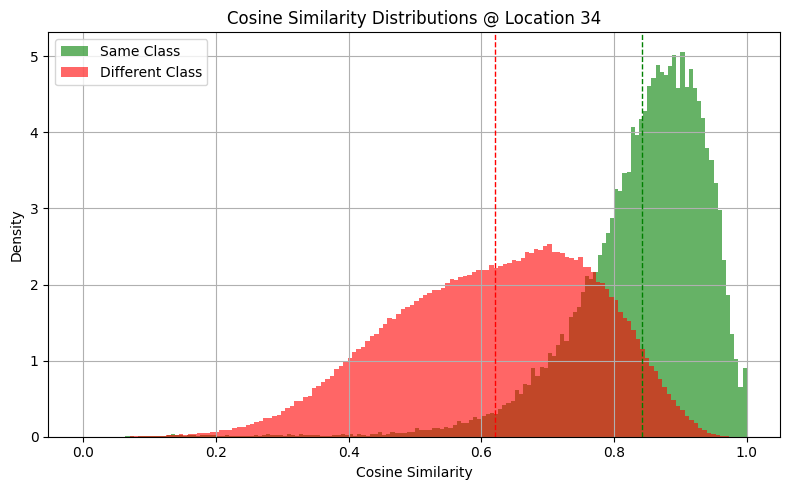

In [18]:
similarity_data = look_at_cosine_similarity_between_latent_embeddings(pre_data)
plot_cosine_similarity_distributions(similarity_data, bins=150)

Location 4 | Avg Same-Class Cosine Sim: 0.9005
Location 4 | Avg Different-Class Cosine Sim: 0.7780


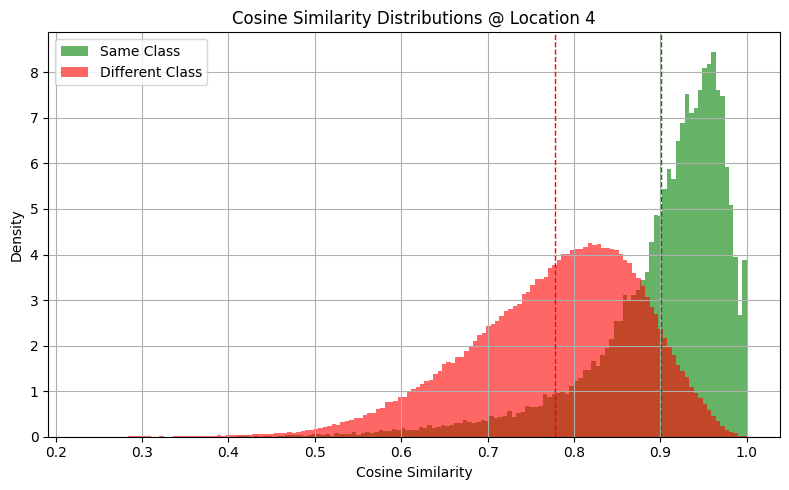

In [ ]:
similarity_data = look_at_cosine_similarity_between_latent_embeddings(pre_data)
plot_cosine_similarity_distributions(similarity_data, bins=150)

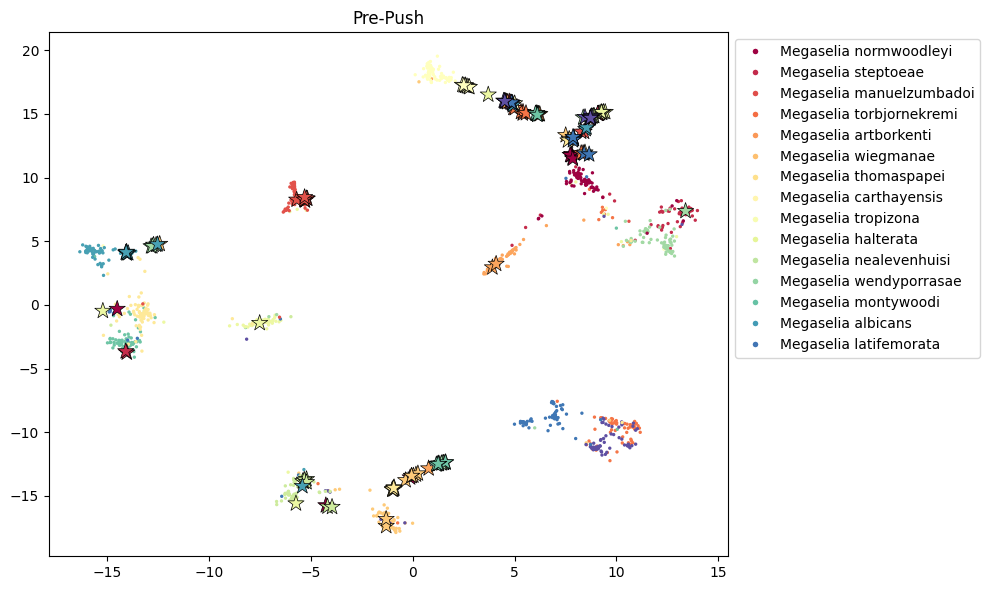

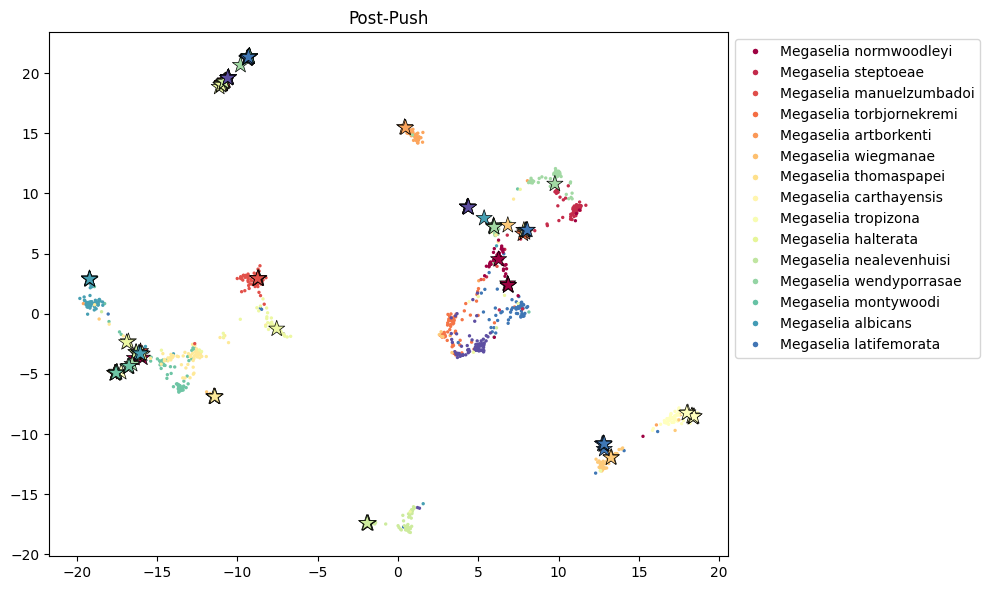

In [22]:
plot(pre_data, title="Pre-Push")
plot(post_data, title="Post-Push")

In [ ]:
# Why are these prototypes all on top of eachother?
# Train image without genetic to see if the last layer optimization is causing issues.
# Alternating optimziation to ensure that genetic accuracy doesn't dominate image accuracy